In [1]:
import Get_data as Gd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from CAE import Encoder, Decoder, Autoencoder
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from tqdm import tqdm

In [2]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA RTX A6000
Using device: cuda:0


In [3]:
directory = '/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# CAE

## Create Dataset for CAE

### Use all the case

In [4]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [5]:
train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)
train_tensor_set = Gd.MyDataset(train_tensor)

In [6]:
val_tensor = torch.tensor(val_np, dtype=torch.float).permute(0, 2, 1)
val_tensor_set = Gd.MyDataset(val_tensor)

In [7]:
train_loader = DataLoader(train_tensor_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_tensor_set, batch_size=5, shuffle=True)

### Test set

In [8]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)

In [9]:
print(folders[-1:])

['/data/Sibo_22Mar2024/case_18/hessian_']


In [10]:
test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)
test_tensor_set = Gd.MyDataset(test_tensor)

## Model Info

In [11]:
# Create an instance of the model
encoder = Encoder(1, 50)
summary(encoder, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [10, 50]                  --
├─Conv1d: 1-1                            [10, 4, 97149]            36
├─Dropout: 1-2                           [10, 4, 97149]            --
├─MaxPool1d: 1-3                         [10, 4, 19429]            --
├─Conv1d: 1-4                            [10, 4, 19429]            132
├─Dropout: 1-5                           [10, 4, 19429]            --
├─MaxPool1d: 1-6                         [10, 4, 3885]             --
├─Conv1d: 1-7                            [10, 1, 3885]             33
├─LeakyReLU: 1-8                         [10, 1, 3885]             --
├─Dropout: 1-9                           [10, 1, 3885]             --
├─MaxPool1d: 1-10                        [10, 1, 777]              --
├─AdaptiveAvgPool1d: 1-11                [10, 1, 100]              --
├─Flatten: 1-12                          [10, 100]                 --
├─Linear: 1-13

In [12]:
decoder = Decoder(50, 1)
summary(decoder, input_size=(10, 50))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [10, 1, 97149]            --
├─Linear: 1-1                            [10, 512]                 26,112
├─Upsample: 1-2                          [10, 1, 1024]             --
├─Conv1d: 1-3                            [10, 1, 1018]             9
├─Linear: 1-4                            [10, 1, 97149]            98,994,831
├─Conv1d: 1-5                            [10, 1, 97149]            2
├─LeakyReLU: 1-6                         [10, 1, 97149]            --
Total params: 99,020,954
Trainable params: 99,020,954
Non-trainable params: 0
Total mult-adds (M): 992.24
Input size (MB): 0.00
Forward/backward pass size (MB): 15.67
Params size (MB): 396.08
Estimated Total Size (MB): 411.75

In [13]:
model = Autoencoder(1, 50)
summary(model, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [10, 1, 97149]            --
├─Encoder: 1-1                           [10, 50]                  --
│    └─Conv1d: 2-1                       [10, 4, 97149]            36
│    └─Dropout: 2-2                      [10, 4, 97149]            --
│    └─MaxPool1d: 2-3                    [10, 4, 19429]            --
│    └─Conv1d: 2-4                       [10, 4, 19429]            132
│    └─Dropout: 2-5                      [10, 4, 19429]            --
│    └─MaxPool1d: 2-6                    [10, 4, 3885]             --
│    └─Conv1d: 2-7                       [10, 1, 3885]             33
│    └─LeakyReLU: 2-8                    [10, 1, 3885]             --
│    └─Dropout: 2-9                      [10, 1, 3885]             --
│    └─MaxPool1d: 2-10                   [10, 1, 777]              --
│    └─AdaptiveAvgPool1d: 2-11           [10, 1, 100]              --
│    └─Flatten

## Train CAE

In [14]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [15]:
def train(model, train_loader, val_loader, criterion, optimizer, metric_train, metric_val, device,scheduler=None, epochs=30):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        for x in tqdm(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            predict= model(x)
            loss = criterion(x, predict)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            relative_train_loss += metric_train(x, predict).item()

        if scheduler != None:
            scheduler.step()
        # print(train_loss, relative_train_loss, len(train_loader))
        train_loss /= len(train_loader)
        relative_train_loss /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        relative_val_loss = 0
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for x in val_loader:
                x = x.to(device)
                predict= model(x)
                val_loss += criterion(x, predict).item()
                relative_val_loss += metric_val(x, predict).item()


            val_loss /= len(val_loader)
            relative_val_loss /= len(val_loader)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [16]:
model = Autoencoder(1, 49).to(device)
optimizer = optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5)

## SCHEDULER

criterion = RMSELoss()
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)

train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_loader,
                                                                                         val_loader,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         metric_train,
                                                                                         metric_val,
                                                                                         device,
                                                                                         scheduler = None,
                                                                                         epochs=30)
# 保存模型的状态字典
torch.save(model.state_dict(), 'CAE.pth')

100%|██████████| 464/464 [00:08<00:00, 55.36it/s]


Epoch 1/30, train Loss: 5.2271371743288535, NRMSE_train_loss: 0.10046247152434983, val Loss: 5.064709190664621, NRMSE_val_loss: 0.09739687091446128


100%|██████████| 464/464 [00:08<00:00, 57.24it/s]


Epoch 2/30, train Loss: 3.941148183212198, NRMSE_train_loss: 0.07574652686939928, val Loss: 4.556349002081772, NRMSE_val_loss: 0.08762085184069543


100%|██████████| 464/464 [00:08<00:00, 56.08it/s]


Epoch 3/30, train Loss: 3.539761522977517, NRMSE_train_loss: 0.06803211357428468, val Loss: 4.320291130707182, NRMSE_val_loss: 0.08308134202299447


100%|██████████| 464/464 [00:08<00:00, 57.80it/s]


Epoch 4/30, train Loss: 3.1562674235681007, NRMSE_train_loss: 0.06066158499793503, val Loss: 4.534050429689473, NRMSE_val_loss: 0.08719203958352065


100%|██████████| 464/464 [00:08<00:00, 56.04it/s]


Epoch 5/30, train Loss: 2.9211412783840607, NRMSE_train_loss: 0.056142600052508304, val Loss: 3.805128212632804, NRMSE_val_loss: 0.0731745037603481


100%|██████████| 464/464 [00:08<00:00, 56.13it/s]


Epoch 6/30, train Loss: 2.677560213182507, NRMSE_train_loss: 0.05146111658541486, val Loss: 3.3663674962931665, NRMSE_val_loss: 0.06473691703687454


100%|██████████| 464/464 [00:08<00:00, 56.71it/s]


Epoch 7/30, train Loss: 2.3903357349336147, NRMSE_train_loss: 0.045940832879217665, val Loss: 3.720299812740293, NRMSE_val_loss: 0.07154321103710039


100%|██████████| 464/464 [00:08<00:00, 55.97it/s]


Epoch 8/30, train Loss: 2.1605608585322726, NRMSE_train_loss: 0.04152469616985462, val Loss: 3.4439228120548973, NRMSE_val_loss: 0.06622834437815793


100%|██████████| 464/464 [00:08<00:00, 56.39it/s]


Epoch 9/30, train Loss: 2.0649276994939507, NRMSE_train_loss: 0.03968668372795821, val Loss: 3.234207098340166, NRMSE_val_loss: 0.06219540714639528


100%|██████████| 464/464 [00:08<00:00, 56.38it/s]


Epoch 10/30, train Loss: 1.9576095311806119, NRMSE_train_loss: 0.03762409223869828, val Loss: 3.1332839460208497, NRMSE_val_loss: 0.06025460481258302


100%|██████████| 464/464 [00:08<00:00, 55.82it/s]


Epoch 11/30, train Loss: 1.786375300188003, NRMSE_train_loss: 0.03433307203672955, val Loss: 2.925630223134468, NRMSE_val_loss: 0.056261320839282765


100%|██████████| 464/464 [00:07<00:00, 58.06it/s]


Epoch 12/30, train Loss: 1.7636051192108928, NRMSE_train_loss: 0.033895442699852944, val Loss: 3.2614285277909247, NRMSE_val_loss: 0.0627188887125973


100%|██████████| 464/464 [00:08<00:00, 55.90it/s]


Epoch 13/30, train Loss: 1.6401031654456566, NRMSE_train_loss: 0.031521808488519286, val Loss: 3.0565278905219047, NRMSE_val_loss: 0.05877854772201129


100%|██████████| 464/464 [00:08<00:00, 56.14it/s]


Epoch 14/30, train Loss: 1.5600329767912626, NRMSE_train_loss: 0.02998290702917388, val Loss: 3.1230885622830225, NRMSE_val_loss: 0.06005854256740161


100%|██████████| 464/464 [00:08<00:00, 57.75it/s]


Epoch 15/30, train Loss: 1.5514734893523414, NRMSE_train_loss: 0.029818398787656093, val Loss: 2.761134523769905, NRMSE_val_loss: 0.05309798688916811


100%|██████████| 464/464 [00:08<00:00, 55.87it/s]


Epoch 16/30, train Loss: 1.537611419527695, NRMSE_train_loss: 0.029551978104603315, val Loss: 3.2862411100288917, NRMSE_val_loss: 0.06319604717708867


100%|██████████| 464/464 [00:08<00:00, 57.60it/s]


Epoch 17/30, train Loss: 1.439072250806052, NRMSE_train_loss: 0.027658113786260242, val Loss: 2.789186552166939, NRMSE_val_loss: 0.053637441247701645


100%|██████████| 464/464 [00:08<00:00, 56.35it/s]


Epoch 18/30, train Loss: 1.3864100790614713, NRMSE_train_loss: 0.026645978164040195, val Loss: 2.7726850766560127, NRMSE_val_loss: 0.05332010961940576


100%|██████████| 464/464 [00:08<00:00, 56.00it/s]


Epoch 19/30, train Loss: 1.3392025693480312, NRMSE_train_loss: 0.025738677833879623, val Loss: 2.7776018689418662, NRMSE_val_loss: 0.053414662159850884


100%|██████████| 464/464 [00:07<00:00, 58.33it/s]


Epoch 20/30, train Loss: 1.351182070271722, NRMSE_train_loss: 0.025968916682076865, val Loss: 3.147872987492331, NRMSE_val_loss: 0.060535159427672625


100%|██████████| 464/464 [00:08<00:00, 56.06it/s]


Epoch 21/30, train Loss: 1.2889231466527642, NRMSE_train_loss: 0.024772337210316468, val Loss: 3.3827413515797975, NRMSE_val_loss: 0.06505179463018632


100%|██████████| 464/464 [00:08<00:00, 55.62it/s]


Epoch 22/30, train Loss: 1.2680471784852703, NRMSE_train_loss: 0.02437111353581964, val Loss: 2.299891834628993, NRMSE_val_loss: 0.04422806094978647


100%|██████████| 464/464 [00:08<00:00, 56.50it/s]


Epoch 23/30, train Loss: 1.2245140682648996, NRMSE_train_loss: 0.023534433023024607, val Loss: 2.8891561072448204, NRMSE_val_loss: 0.05555990543858758


100%|██████████| 464/464 [00:08<00:00, 55.84it/s]


Epoch 24/30, train Loss: 1.2583575652077281, NRMSE_train_loss: 0.02418488491495172, val Loss: 2.696869859407688, NRMSE_val_loss: 0.05186214559743631


100%|██████████| 464/464 [00:08<00:00, 56.34it/s]


Epoch 25/30, train Loss: 1.2138061448931694, NRMSE_train_loss: 0.02332863301050785, val Loss: 2.826457633540548, NRMSE_val_loss: 0.05435418258902842


100%|██████████| 464/464 [00:08<00:00, 55.28it/s]


Epoch 26/30, train Loss: 1.1764378482154731, NRMSE_train_loss: 0.022610436605112947, val Loss: 2.739568474477735, NRMSE_val_loss: 0.05268326093410623


100%|██████████| 464/464 [00:08<00:00, 55.79it/s]


Epoch 27/30, train Loss: 1.1537324887025973, NRMSE_train_loss: 0.022174053034616698, val Loss: 2.5698506564929566, NRMSE_val_loss: 0.049419503193348646


100%|██████████| 464/464 [00:08<00:00, 57.12it/s]


Epoch 28/30, train Loss: 1.1318861045714081, NRMSE_train_loss: 0.021754178507574672, val Loss: 2.7421698107801635, NRMSE_val_loss: 0.05273328596276456


100%|██████████| 464/464 [00:08<00:00, 55.55it/s]


Epoch 29/30, train Loss: 1.1436139481977141, NRMSE_train_loss: 0.02197958069355709, val Loss: 2.9757003388528167, NRMSE_val_loss: 0.057224193700300206


100%|██████████| 464/464 [00:08<00:00, 57.68it/s]


Epoch 30/30, train Loss: 1.07171438454554, NRMSE_train_loss: 0.020597713797730555, val Loss: 2.7669250605435205, NRMSE_val_loss: 0.053209341628926585


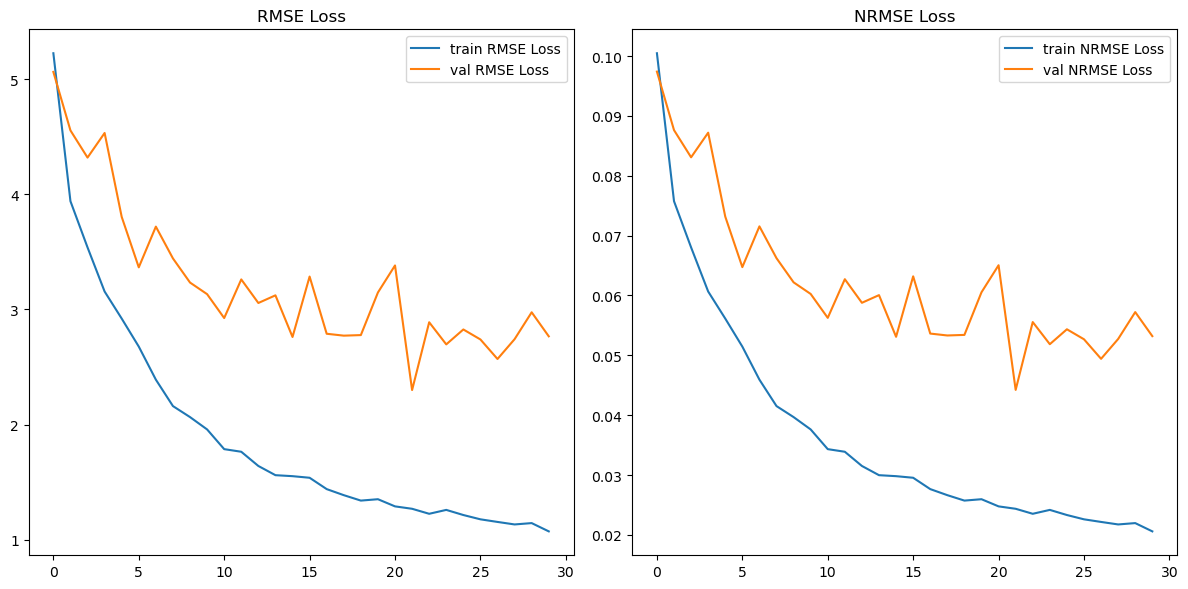

In [17]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
plt.show()


## Result

In [18]:
def draw_pic(x, y, coords):
    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Input {i+1}')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Predict {i+1}')
    plt.show()
    plt.close()


In [19]:
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
xycoords_check = np.load(xyfile)

In [20]:
model = Autoencoder(1, 49)
# 加载保存的状态字典
state_dict = torch.load('CAE.pth')
model.load_state_dict(state_dict)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(4, 1, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (leaky_relu): LeakyReLU(negative_slope=0.3)
    (dropout3): Dropout(p=0.1, inplace=False)
    (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (avg_pool): AdaptiveAvgPool1d(output_size=100)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=100, out_features=49, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=49, out_features=512, bias=True)
 

In [21]:
test_tensor = test_tensor.to(device)
y = model(test_tensor)
criterion = RMSELoss()
metric = NRMSE(test_tensor)

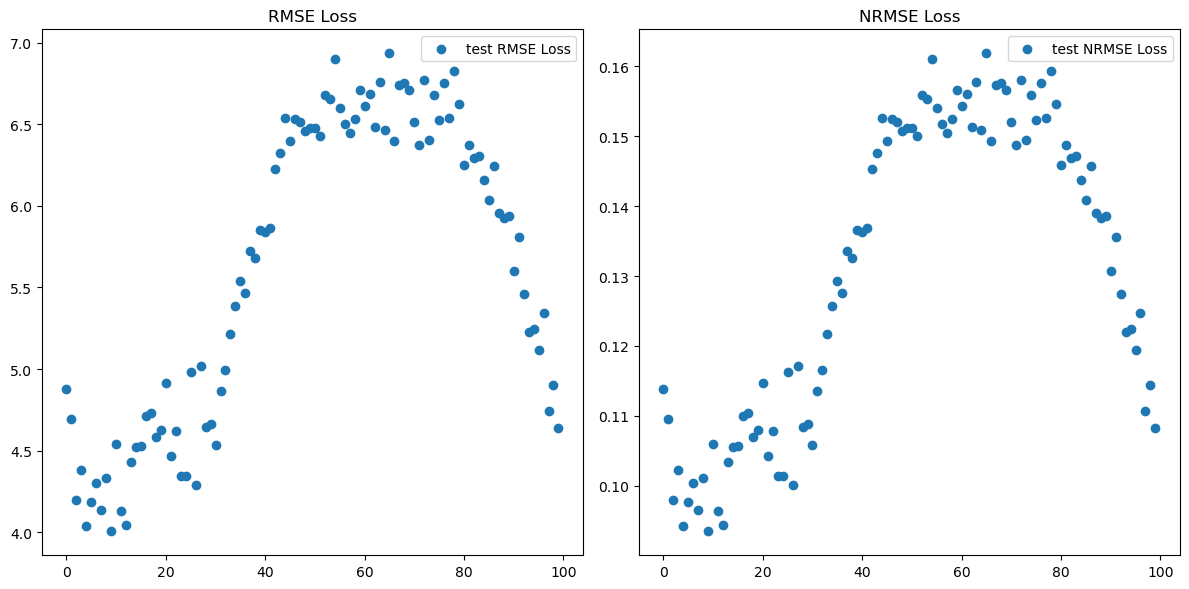

In [22]:
test_rmse=[]
test_nrmse=[]
for i in range(len(test_tensor)):
    nrmse = metric(test_tensor[i], y[i])
    rmse = criterion(test_tensor[i], y[i])

    test_rmse.append(rmse.cpu().detach().numpy())
    test_nrmse.append(nrmse.cpu().detach().numpy())


x = np.arange(0, 100)
test_rmse = np.array(test_rmse)
test_nrmse = np.array(test_nrmse)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_rmse)
np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠
plt.show()

In [23]:
y_np = y[:5].cpu().detach().numpy()
x_np = test_tensor[:5].cpu().detach().numpy()
rmse = criterion(test_tensor, y).item()
nrmse = metric(test_tensor, y).item()
print(f"Ave RMSE test loss: {rmse}")
print(f"Ave NRMSE test loss: {nrmse}")

Ave RMSE test loss: 5.702610969543457
Ave NRMSE test loss: 0.13310179114341736


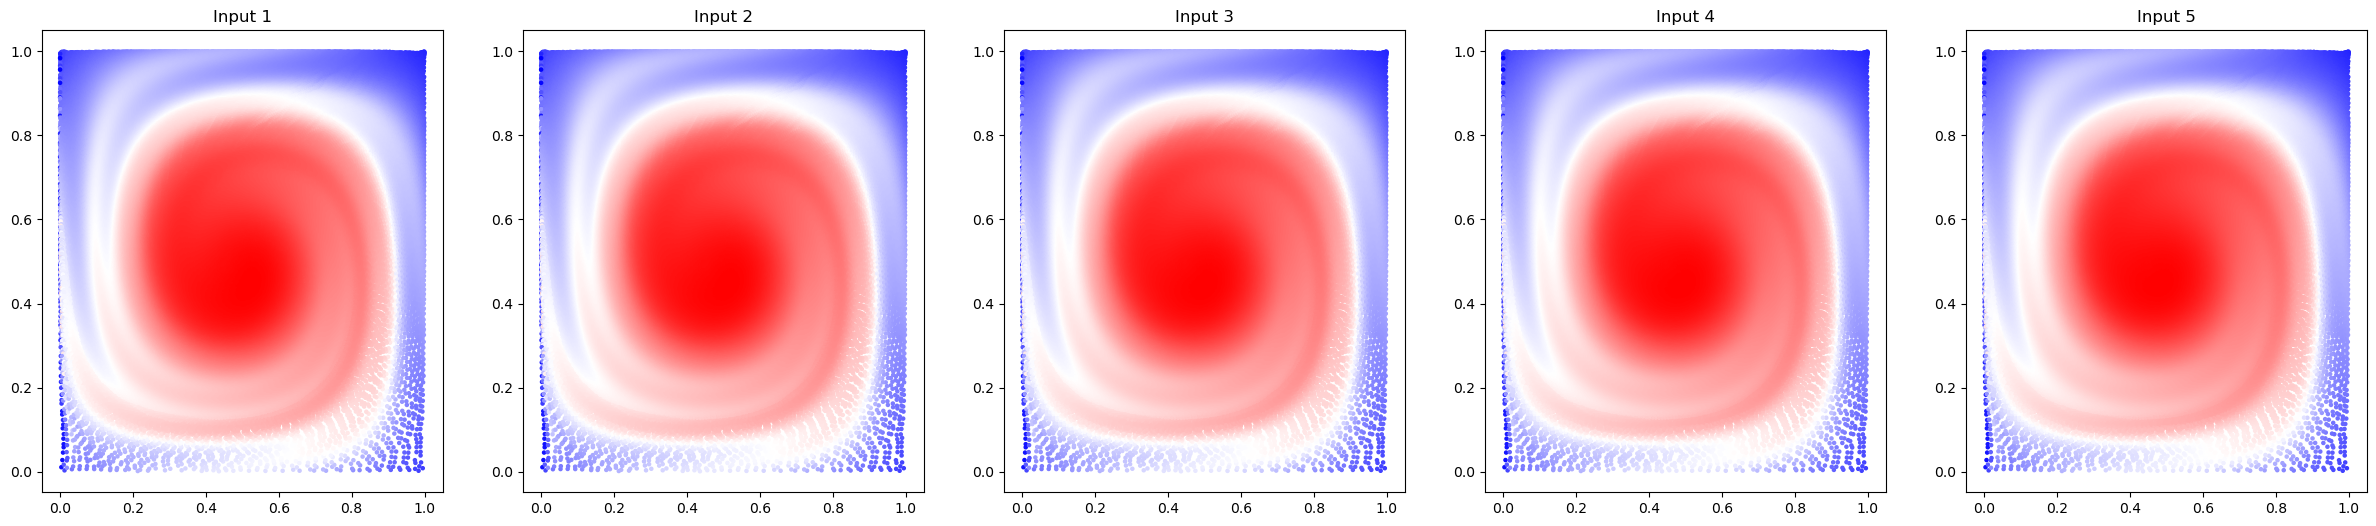

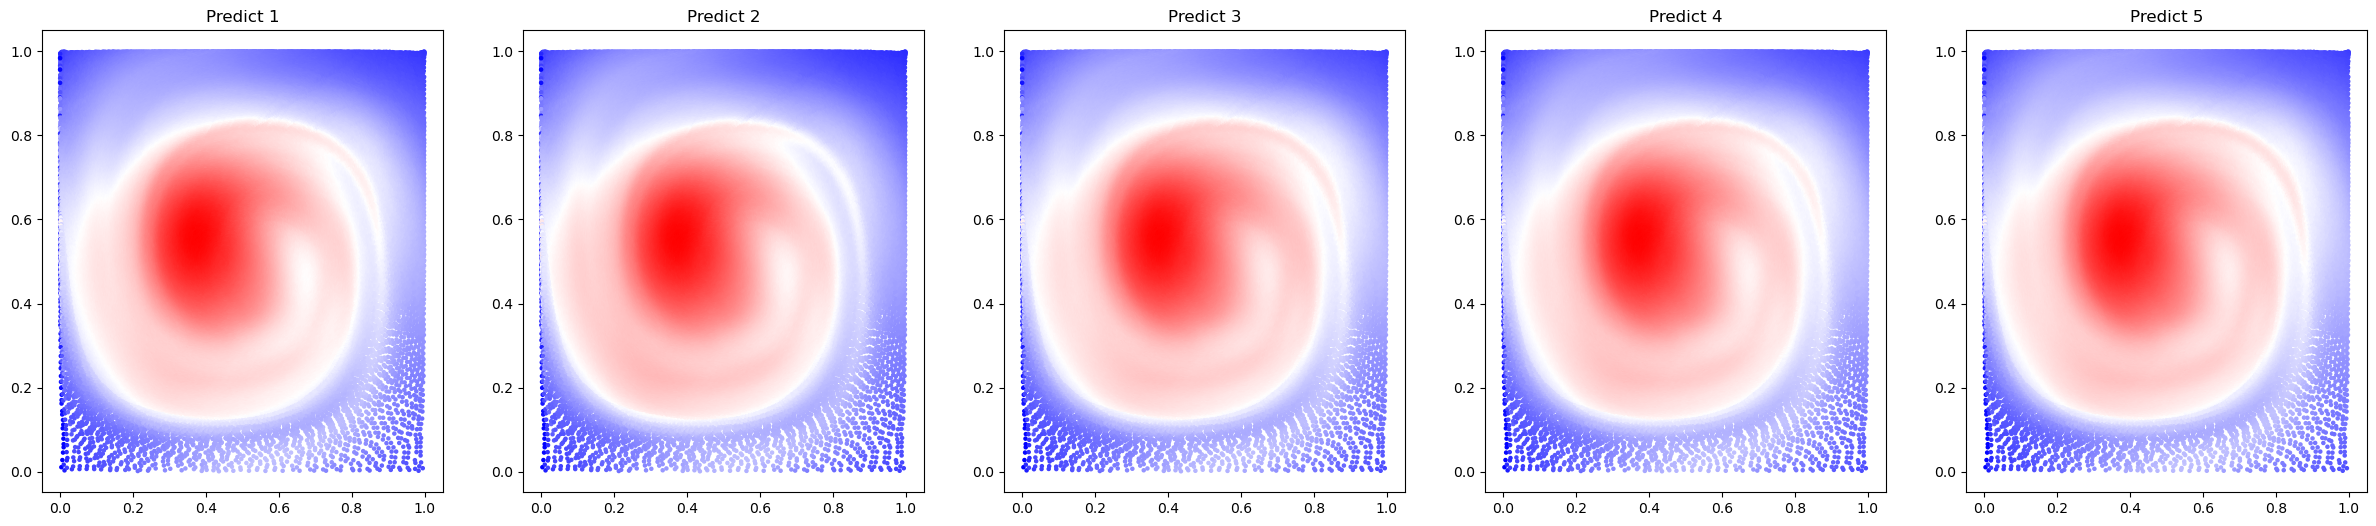

In [24]:
draw_pic(x_np, y_np, xycoords_check)